In [14]:
import requests
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import spacy
import re
from networkx.algorithms import community

class TextAnalysis:
    """
    A class for text analysis and network visualization.

    Args:
        nlp_model (str): The spaCy model to use for natural language processing.

    Attributes:
        nlp (spacy.lang): The spaCy language model for text processing.

    Methods:
        get_data(url, header_cutoff, footer_cutoff):
            Retrieve and preprocess text data from a URL.

        extract_entities(text):
            Extract and filter named entities from the provided text.

        get_network_data(entities, text):
            Create network data based on entities appearing in the same sentence.

        visualize_ego_graph(filename, ego_node, radius=1, node_size=200, font_size=10, ego_color='red', figsize=(10, 10)):
            Visualize an ego network graph centered around a specific node.

    """
    def __init__(self, nlp_model='en_core_web_sm'):
        """
        Initialize the TextAnalysis class.

        Args:
            nlp_model (str): The spaCy model to use for natural language processing. To download: python -m spacy download en_core_web_sm
        """
        self.nlp = spacy.load(nlp_model)

    def get_data(self, url, header_cutoff, footer_cutoff):
        """
        Retrieve and preprocess text data from a URL.

        Args:
            url (str): The URL of the text data.
            header_cutoff (str): The header to cut off the text.
            footer_cutoff (str): The footer to cut off the text.

        Returns:
            str: Preprocessed text data.
        """
        text = requests.get(url).text
        # Remove header and footer
        header_index = text.index(header_cutoff)
        footer_index = text.rindex(footer_cutoff)
        text = text[header_index:footer_index]

        # Pre-processing to clean the text
        text = text.replace('\r', ' ').replace('\n', ' ')
        text = text.replace('â\x80\x99', '\'').replace('â\x80\x9c', '"').replace('â\x80\x9d', '"').replace('â\x80\x94', ' ')
        return text

    def extract_entities(self, text):
        """
        Extract and filter named entities from the provided text.

        Args:
            text (str): The text from which to extract entities.

        Returns:
            list: List of extracted and filtered entities.
        """
        doc = self.nlp(text)
        entities = set()
        for ent in doc.ents:
            if ent.label_ in ['PERSON', 'ORG', 'GPE']:
                entity = ent.text.strip()
                if "'s" in entity:
                    entity = entity.split("'s")[0].strip()
                if entity:
                    entities.add(entity)
        return list(entities)

    def get_network_data(self, entities, text):
        """
        Create network data based on entities appearing in the same sentence.

        Args:
            entities (list): List of extracted entities.
            text (str): The text from which to extract network data.

        Returns:
            pd.DataFrame: DataFrame containing network data.
        """
        final_sources = []
        final_targets = []
        
        for sentence in text.split('.'):
            sentence_entities = [entity for entity in entities if entity in sentence]
            if len(sentence_entities) > 1:
                source = sentence_entities[0]
                targets = sentence_entities[1:]
                for target in targets:
                    final_sources.append(source)
                    final_targets.append(target)

        df = pd.DataFrame({'source': final_sources, 'target': final_targets})
        
        # Drop duplicates based on 'source' and 'target'
        df = df.drop_duplicates()

        return df


    def visualize_ego_graph(self, filename, ego_node, radius=1, node_size=200, font_size=10, ego_color='red', figsize=(10, 10)):
        """
        Visualize an ego network graph centered around a specific node.

        Args:
            filename (str): The TSV file containing network data.
            ego_node (str): The node around which to create the ego graph.
            radius (int): The radius for the ego graph.
            node_size (int): Size of nodes in the graph.
            font_size (int): Size of node labels' font.
            ego_color (str): Color of the ego node.
            figsize (tuple): Figure size for the graph visualization.
        """
        df = pd.read_csv(filename, delimiter='\t')
        G = nx.from_pandas_edgelist(df, source='source', target='target')

        ego_graph = nx.ego_graph(G, ego_node, radius=radius)
        pos = nx.spring_layout(ego_graph, k=0.5, iterations=50)

        plt.figure(figsize=figsize)
        nx.draw(ego_graph, pos, with_labels=True, node_size=node_size, font_size=font_size, font_color='black', node_color='lightblue', edge_color='gray', width=1.0)
        nx.draw_networkx_nodes(ego_graph, pos, nodelist=[ego_node], node_color=ego_color, node_size=node_size)
        plt.show()

    def detect_communities(self, network_data_path):
        """
        Detect and return communities within the network data.

        Args:
            network_data_path (str): Path to the network data file in TSV format.

        Returns:
            list of lists: List of communities, where each community is a list of node names.
        """
        # Load the network data from the TSV file
        G = nx.read_edgelist(network_data_path, delimiter='\t')

        # Perform community detection using the Louvain method
        communities = list(community.greedy_modularity_communities(G))

        return [list(community) for community in communities]

    def show_communities_as_graph(self, network_data_path):
        """
        Display the detected communities within the network data as a graph.

        Args:
            network_data_path (str): Path to the network data file in TSV format.
        """
        G = nx.read_edgelist(network_data_path, delimiter='\t')
        communities = self.detect_communities(network_data_path)
        
        # Create a color map for communities
        community_colors = {}
        for i, community in enumerate(communities, start=1):
            color = plt.cm.tab20(i % 20)  # Assign a distinct color to each community
            for node in community:
                community_colors[node] = color

        # Adjust the node and figure sizes
        node_size = 50  # Adjust this value as needed
        fig_size = (12, 12)  # Adjust the figure size as needed
        plt.figure(figsize=fig_size)

        # Use a different layout algorithm (e.g., Kamada-Kawai)
        pos = nx.kamada_kawai_layout(G)

        # Draw the graph with nodes colored by community
        node_colors = [community_colors[node] for node in G.nodes()]
        nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=node_size)

        # Configure the layout
        plt.axis('off')

        # Show the graph
        plt.show()

    def show_communities_as_list(self, network_data_path):
        """
        Display the detected communities within the network data.

        Args:
            network_data_path (str): Path to the network data file in TSV format.
        """
        communities = self.detect_communities(network_data_path)
        for i, community in enumerate(communities, start=1):
            print(f"Community {i}: {', '.join(community)}")


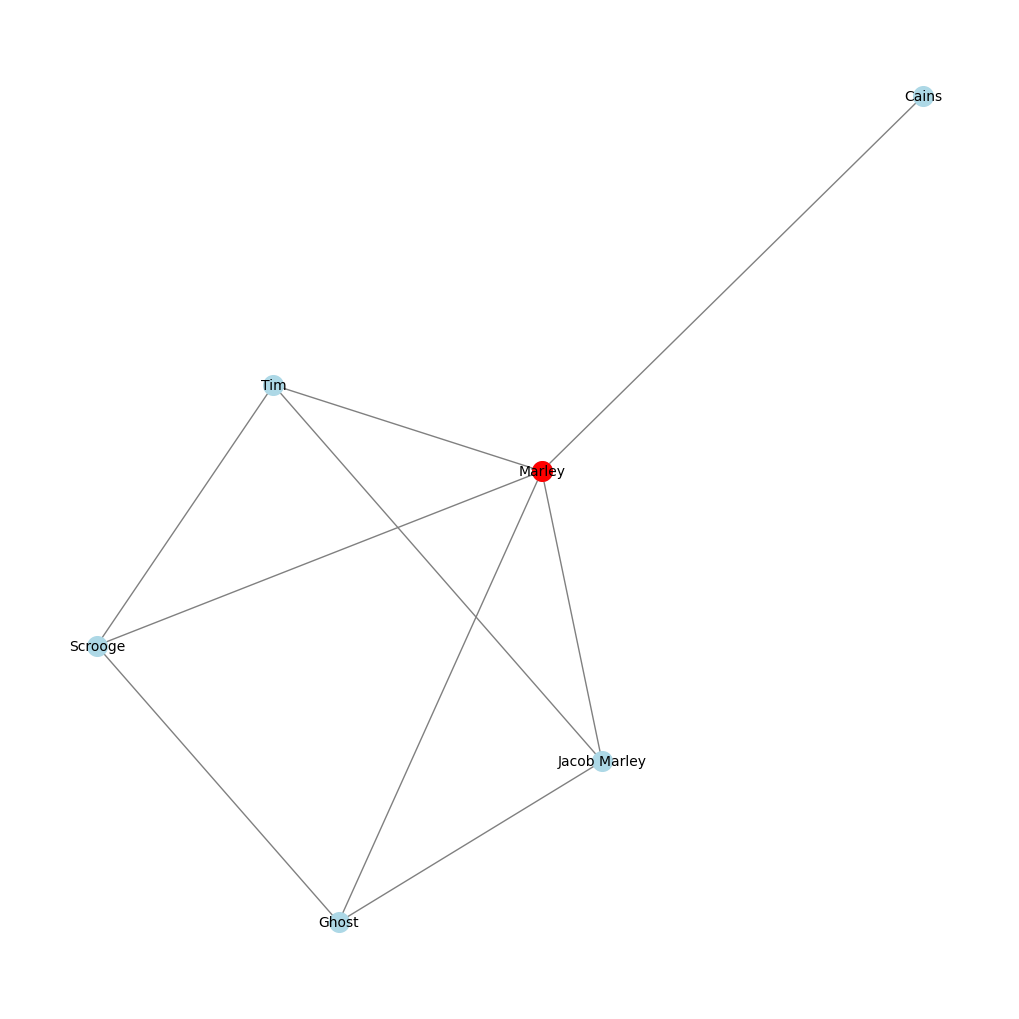

In [15]:
# First, create an instance of the TextAnalysis class
text_analyzer = TextAnalysis()

# Define the URL and cutoffs for the data
url = "https://www.gutenberg.org/cache/epub/46/pg46.txt" #A Christmas Carol in Prose; Being a Ghost Story of Christmas; Gutenberg Project
header_cutoff = "MARLEY was dead"
footer_cutoff = "*** END OF THE PROJECT GUTENBERG EBOOK A CHRISTMAS CAROL IN PROSE; BEING A GHOST STORY OF CHRISTMAS ***"

# Get the text data from the URL and apply preprocessing
text_data = text_analyzer.get_data(url, header_cutoff, footer_cutoff)

# Extract entities from the text
entities = text_analyzer.extract_entities(text_data)

# Get network data based on entities appearing in the same sentence
network_data = text_analyzer.get_network_data(entities, text_data)

# Save the network data to a TSV file
network_data.to_csv("network_data_2.tsv", sep='\t', index=False)

# Visualize the ego graph for a specific node
ego_node = "Marley"
text_analyzer.visualize_ego_graph("network_data_2.tsv", ego_node)



In [16]:
# Example usage:
text_analyzer.show_communities_as_list("network_data_2.tsv")

Community 1: thou hast, Orson, Groom, Tank, Scrooge, Fred, Gothic, United States', Ding, Plenty, Giant, Dick Wilkins, Ali Baba, Valentine, Whitechapel, Welsh, baker, Star, Whereat Scrooge, Ebenezer Scrooge, Laocoön, Spectre, Merry  Christmas, Scrooge Scrooge, Death, London, Uncle Scrooge, Founder, God, Parrot, Poulterer
Community 2: Belinda, Peter Cratchit, Us, Bob  Cratchit, Cratchits, Cratchit, Joe, Peter, Time, Parks, Martha, Robert, Hurrah, Tiny Tim, Bob, Belinda Cratchit, Tim, Bob Cratchit, Peter  Cratchit, Joe  Miller
Community 3: Future, Spirit, Saint Dunstan, Marley, the Invisible World, the Total Abstinence Principle, Ghost, Jacob  Marley, Jacob, Jacob Marley, Ward, Thank'ee, Phantom
Community 4: Hallo, Merry, Dick, Fezziwig, Ebenezer, Jack Robinson, Turkey, Fezziwigs, Hilli-ho, Halloo
Community 5: Prophet, Queens of Sheba, Belshazzars, Abels, Angelic, Pharaoh, Cains
Community 6: Cold Roast, Boiled, Roger de Coverley, Cold Boiled, Roast
Community 7: Camden, blindman, Cornhill,

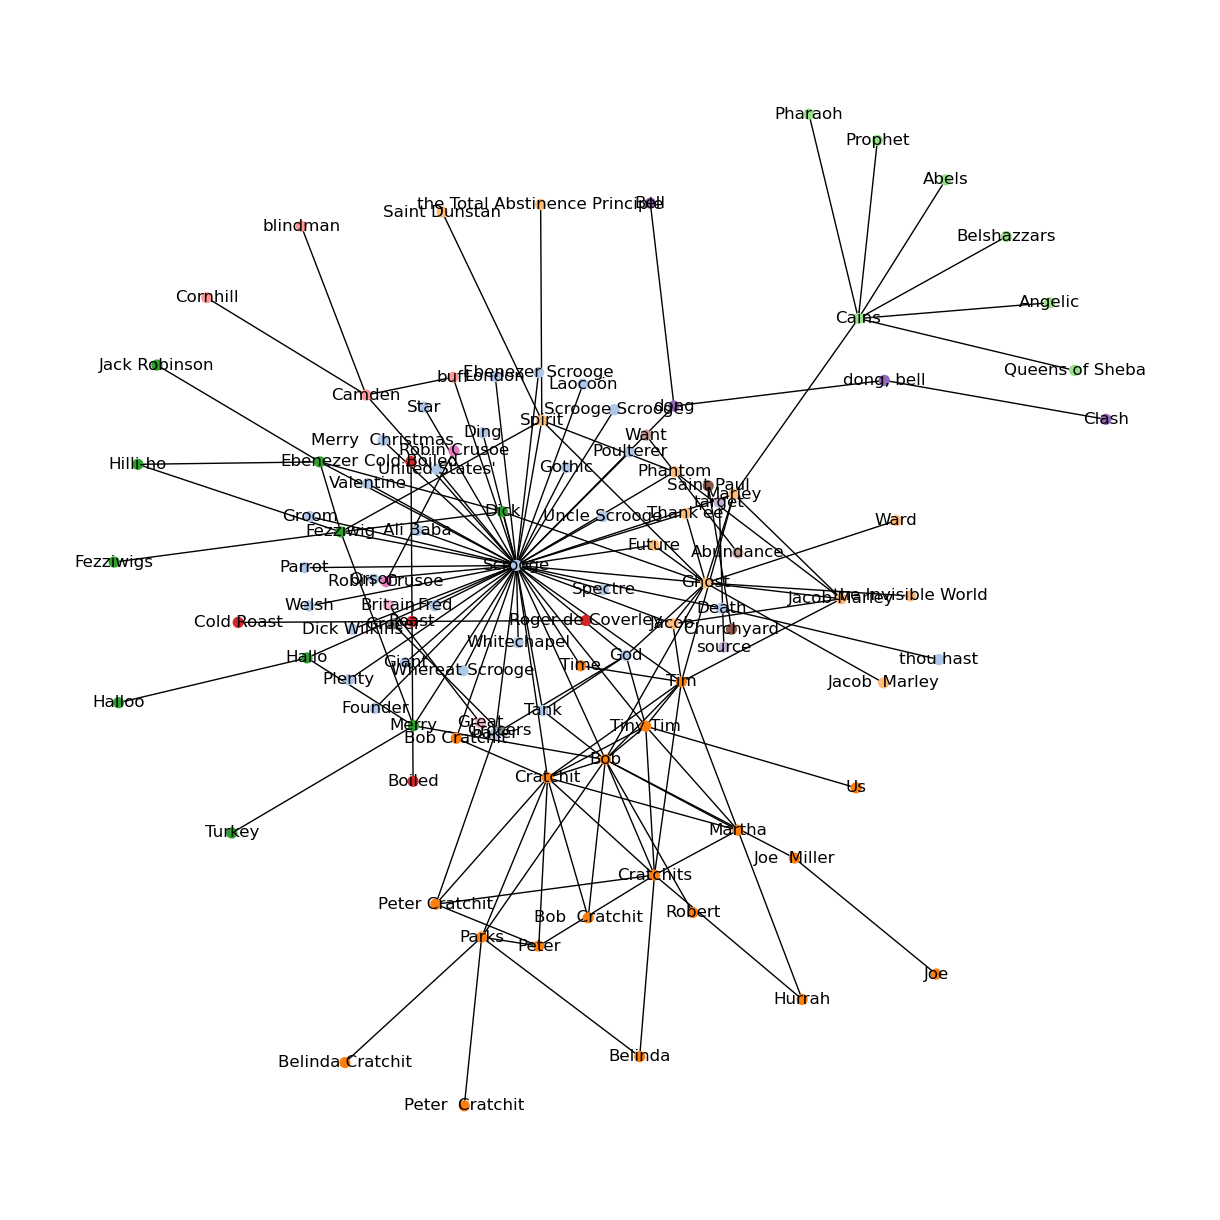

In [17]:
# Example usage:
text_analyzer.show_communities_as_graph("network_data_2.tsv")